In [2]:
import torch
import torch.nn as nn
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
import PIL
import pandas as pd

import os
import math

# Collaborative filtering

* When we have users and products and try to recommend the product that would be useful for users

* The usecase is not just limited to shoping etc. It is about how to define user and product. If we choose patients as users and treatments as products, it can be thought as a collaborative filtering too

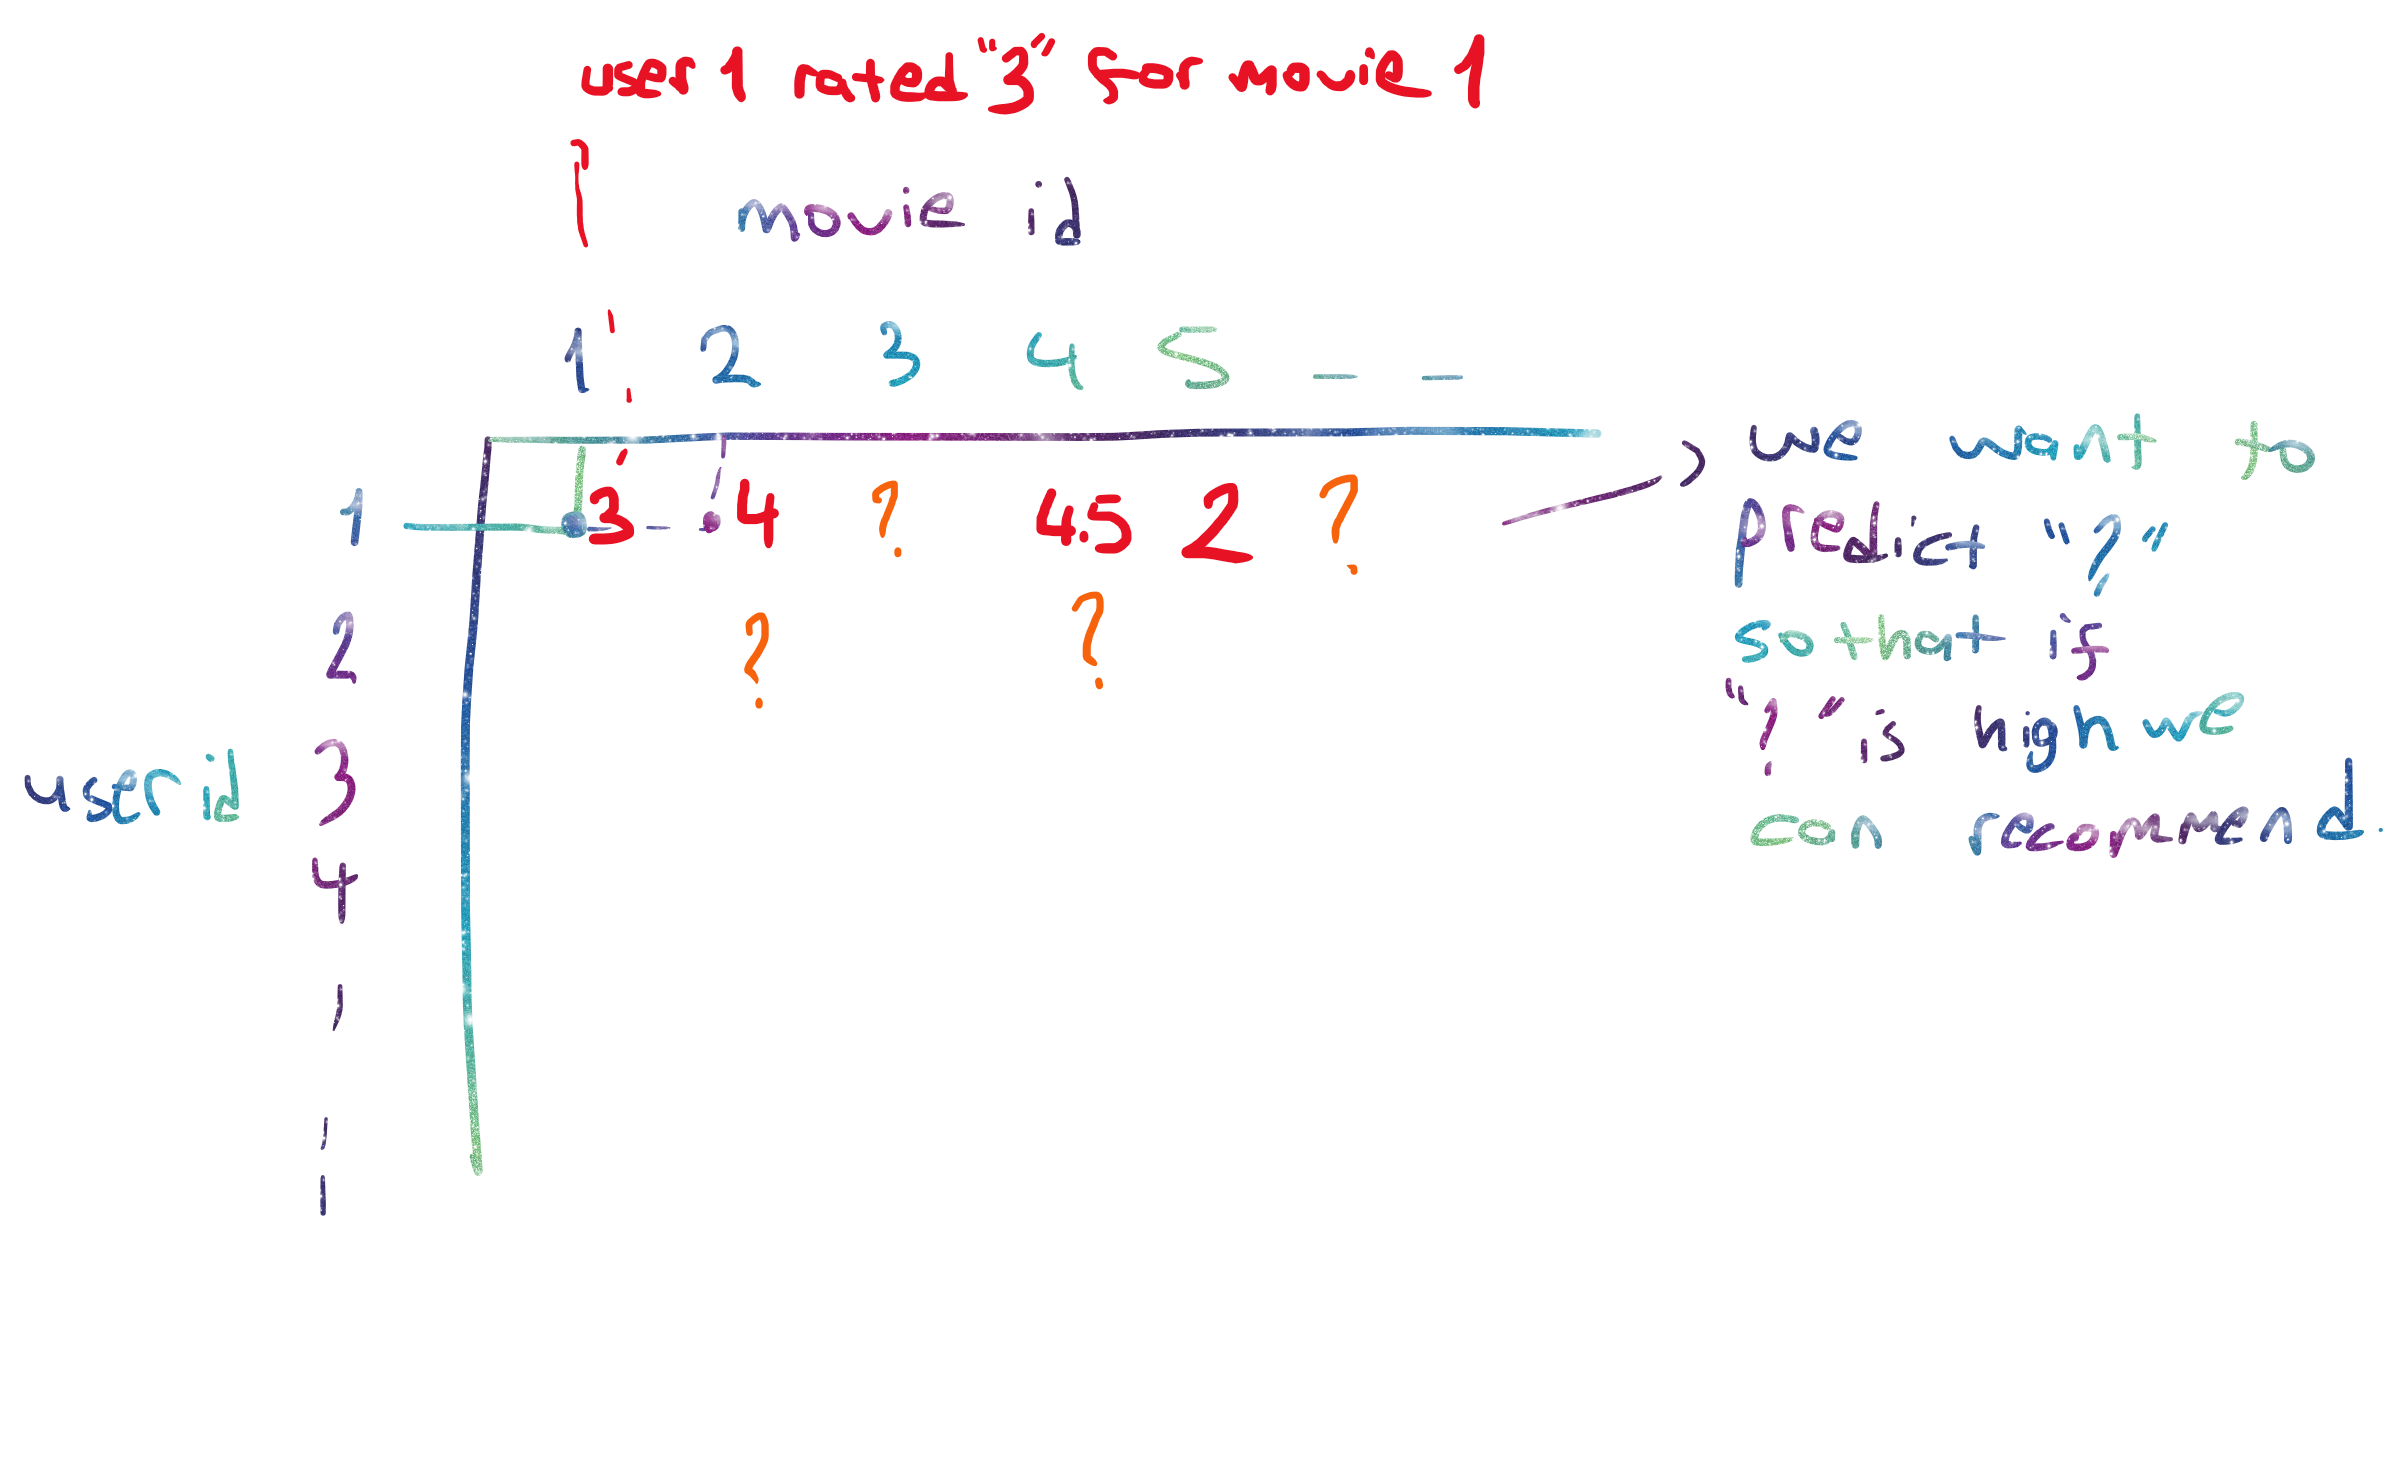

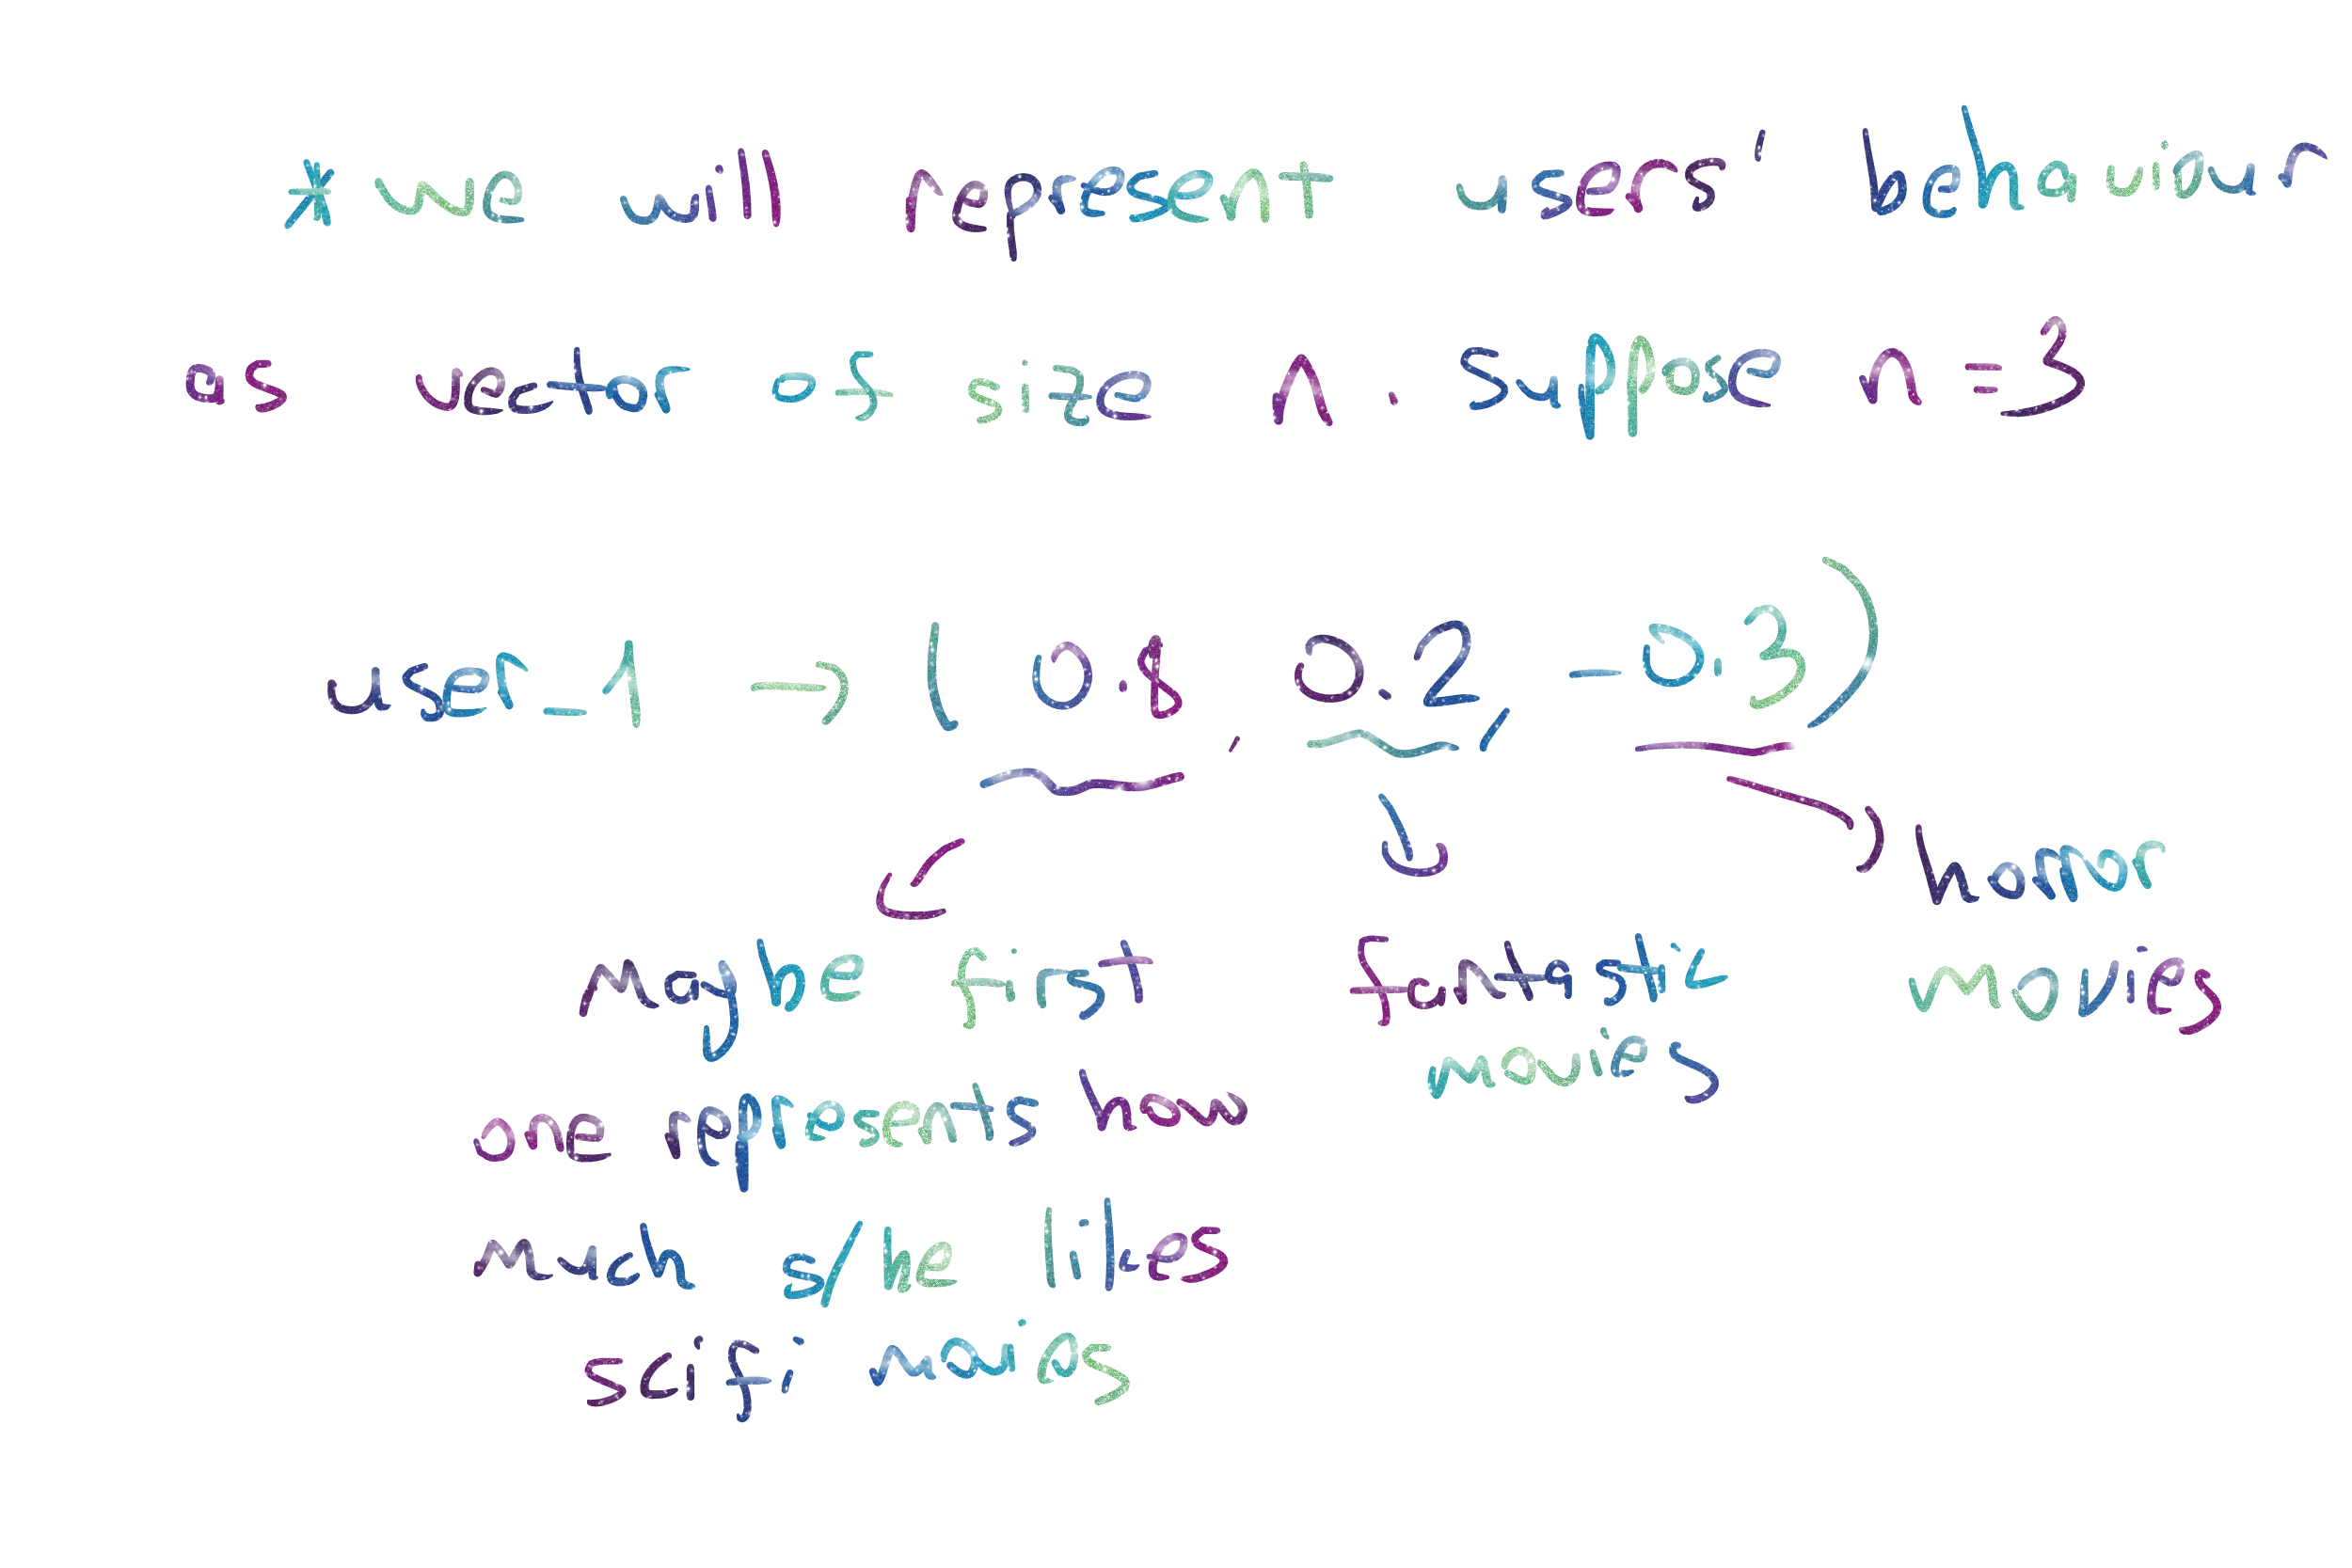

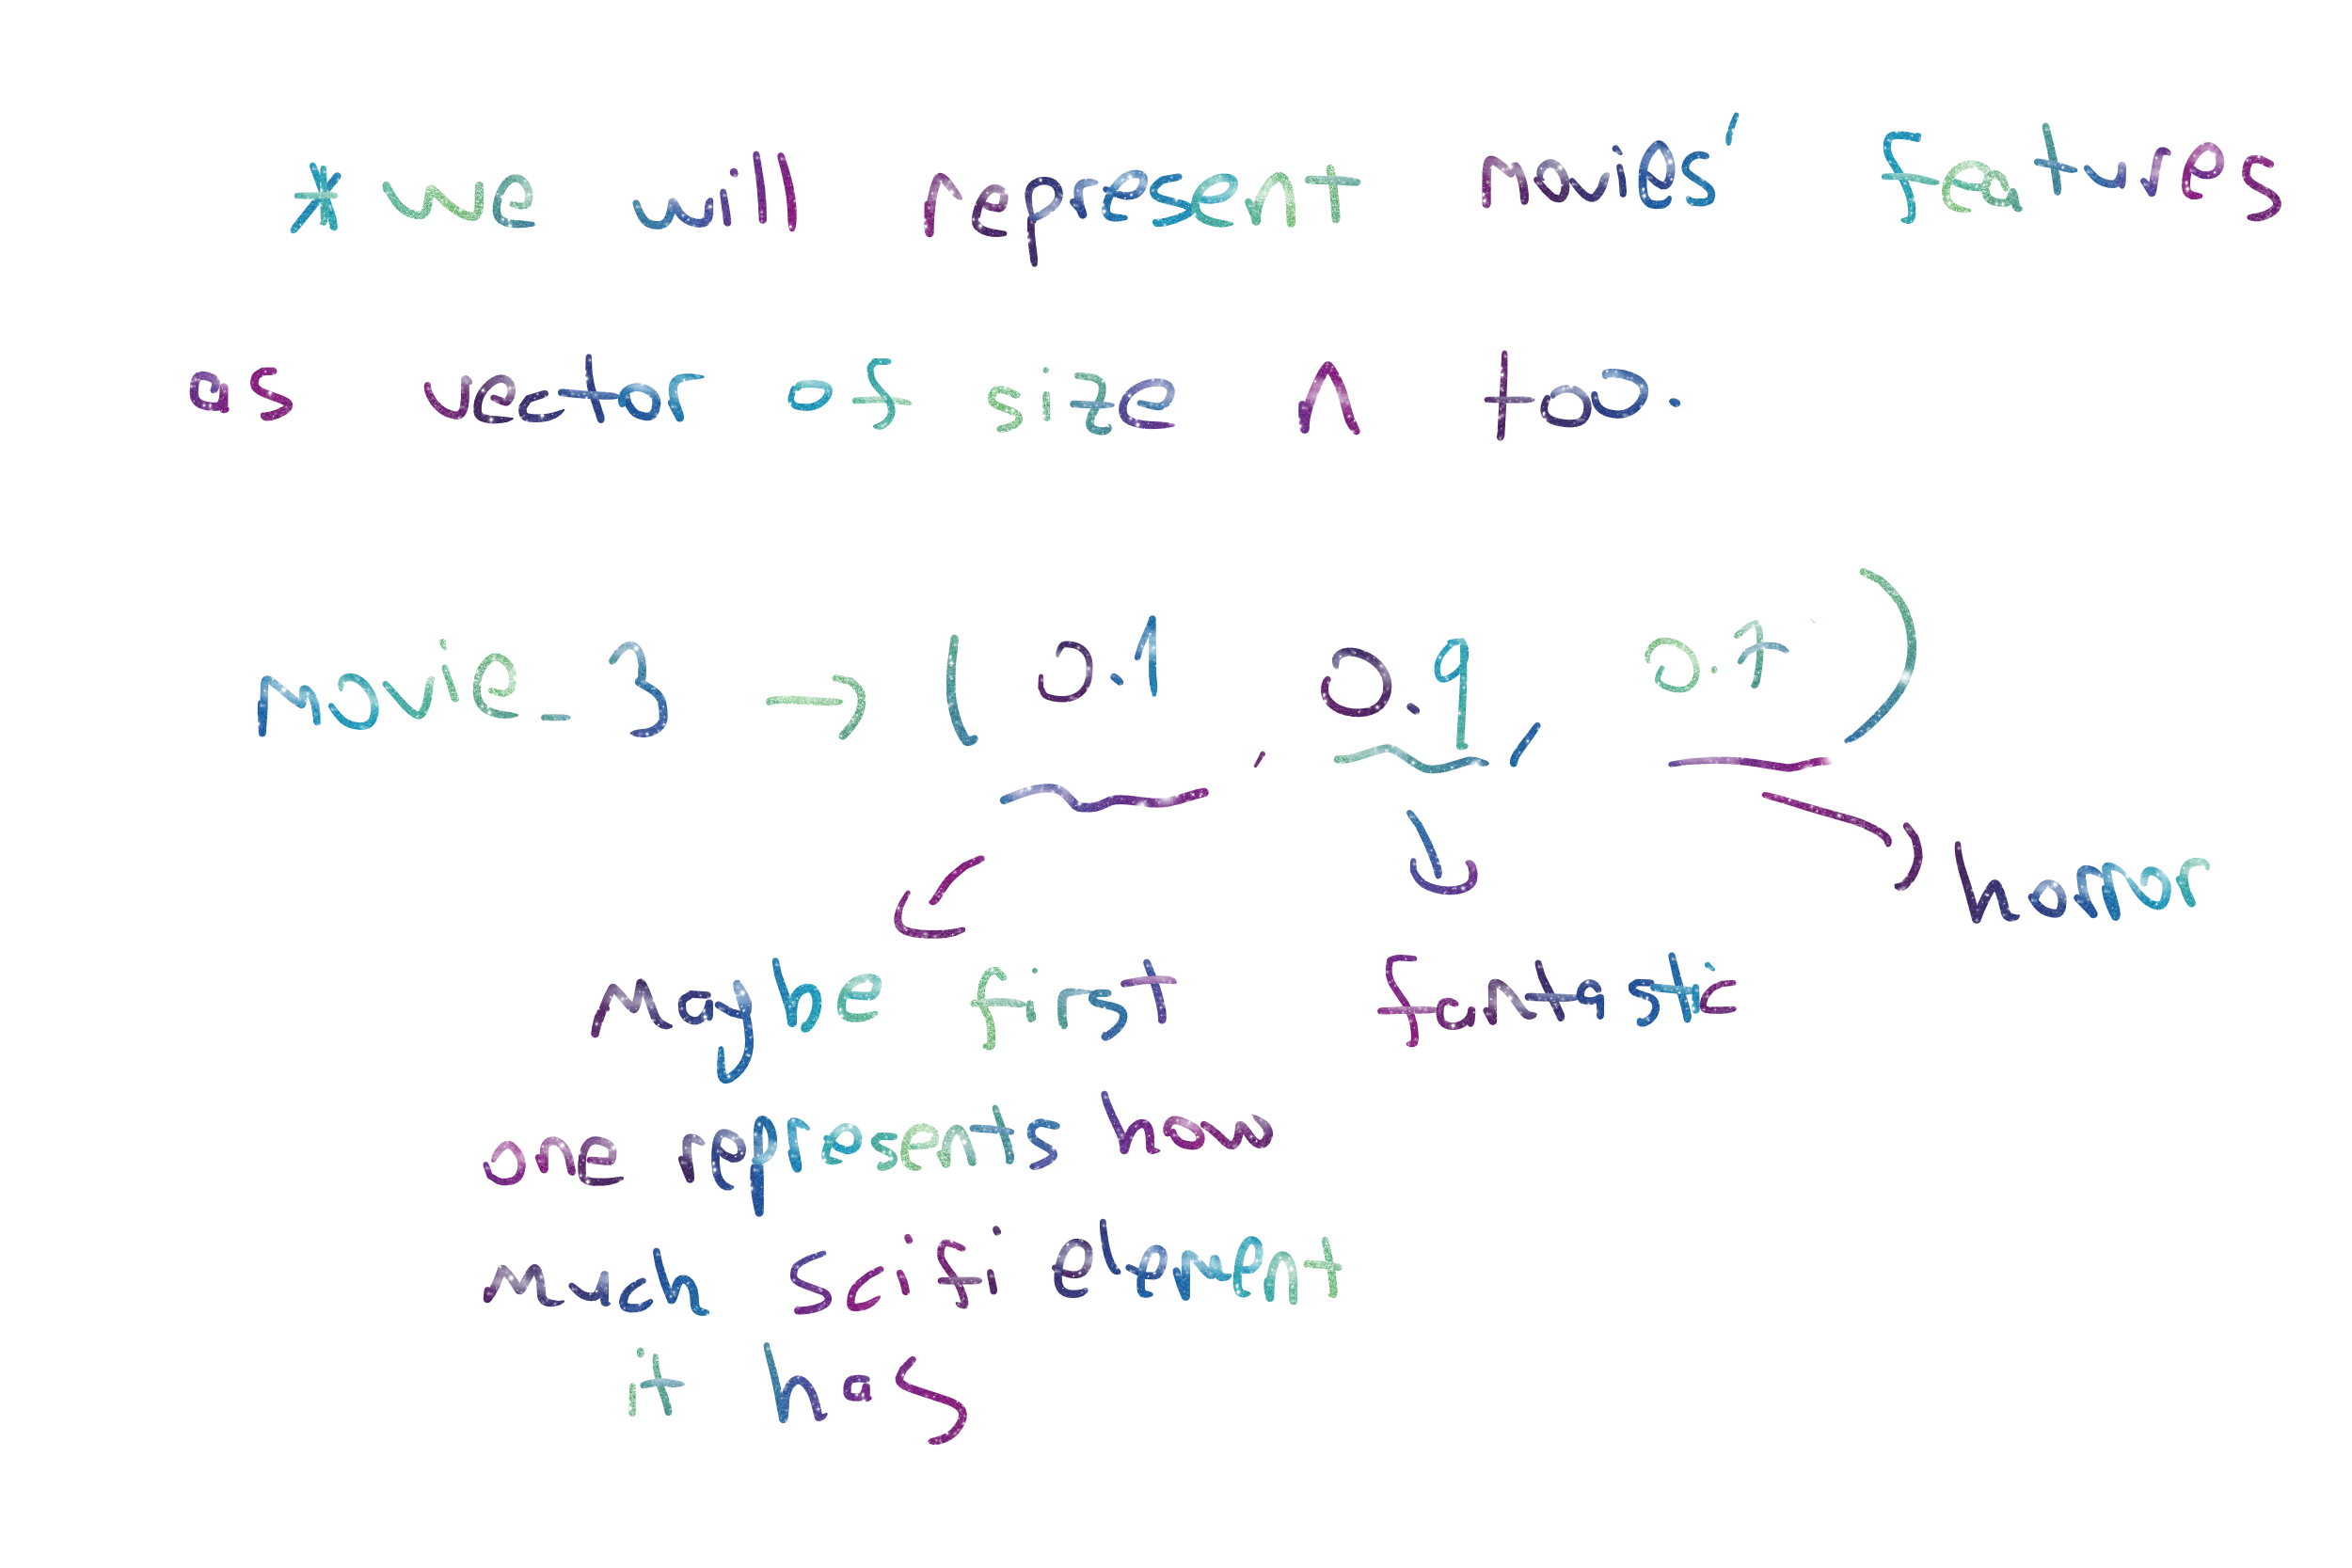

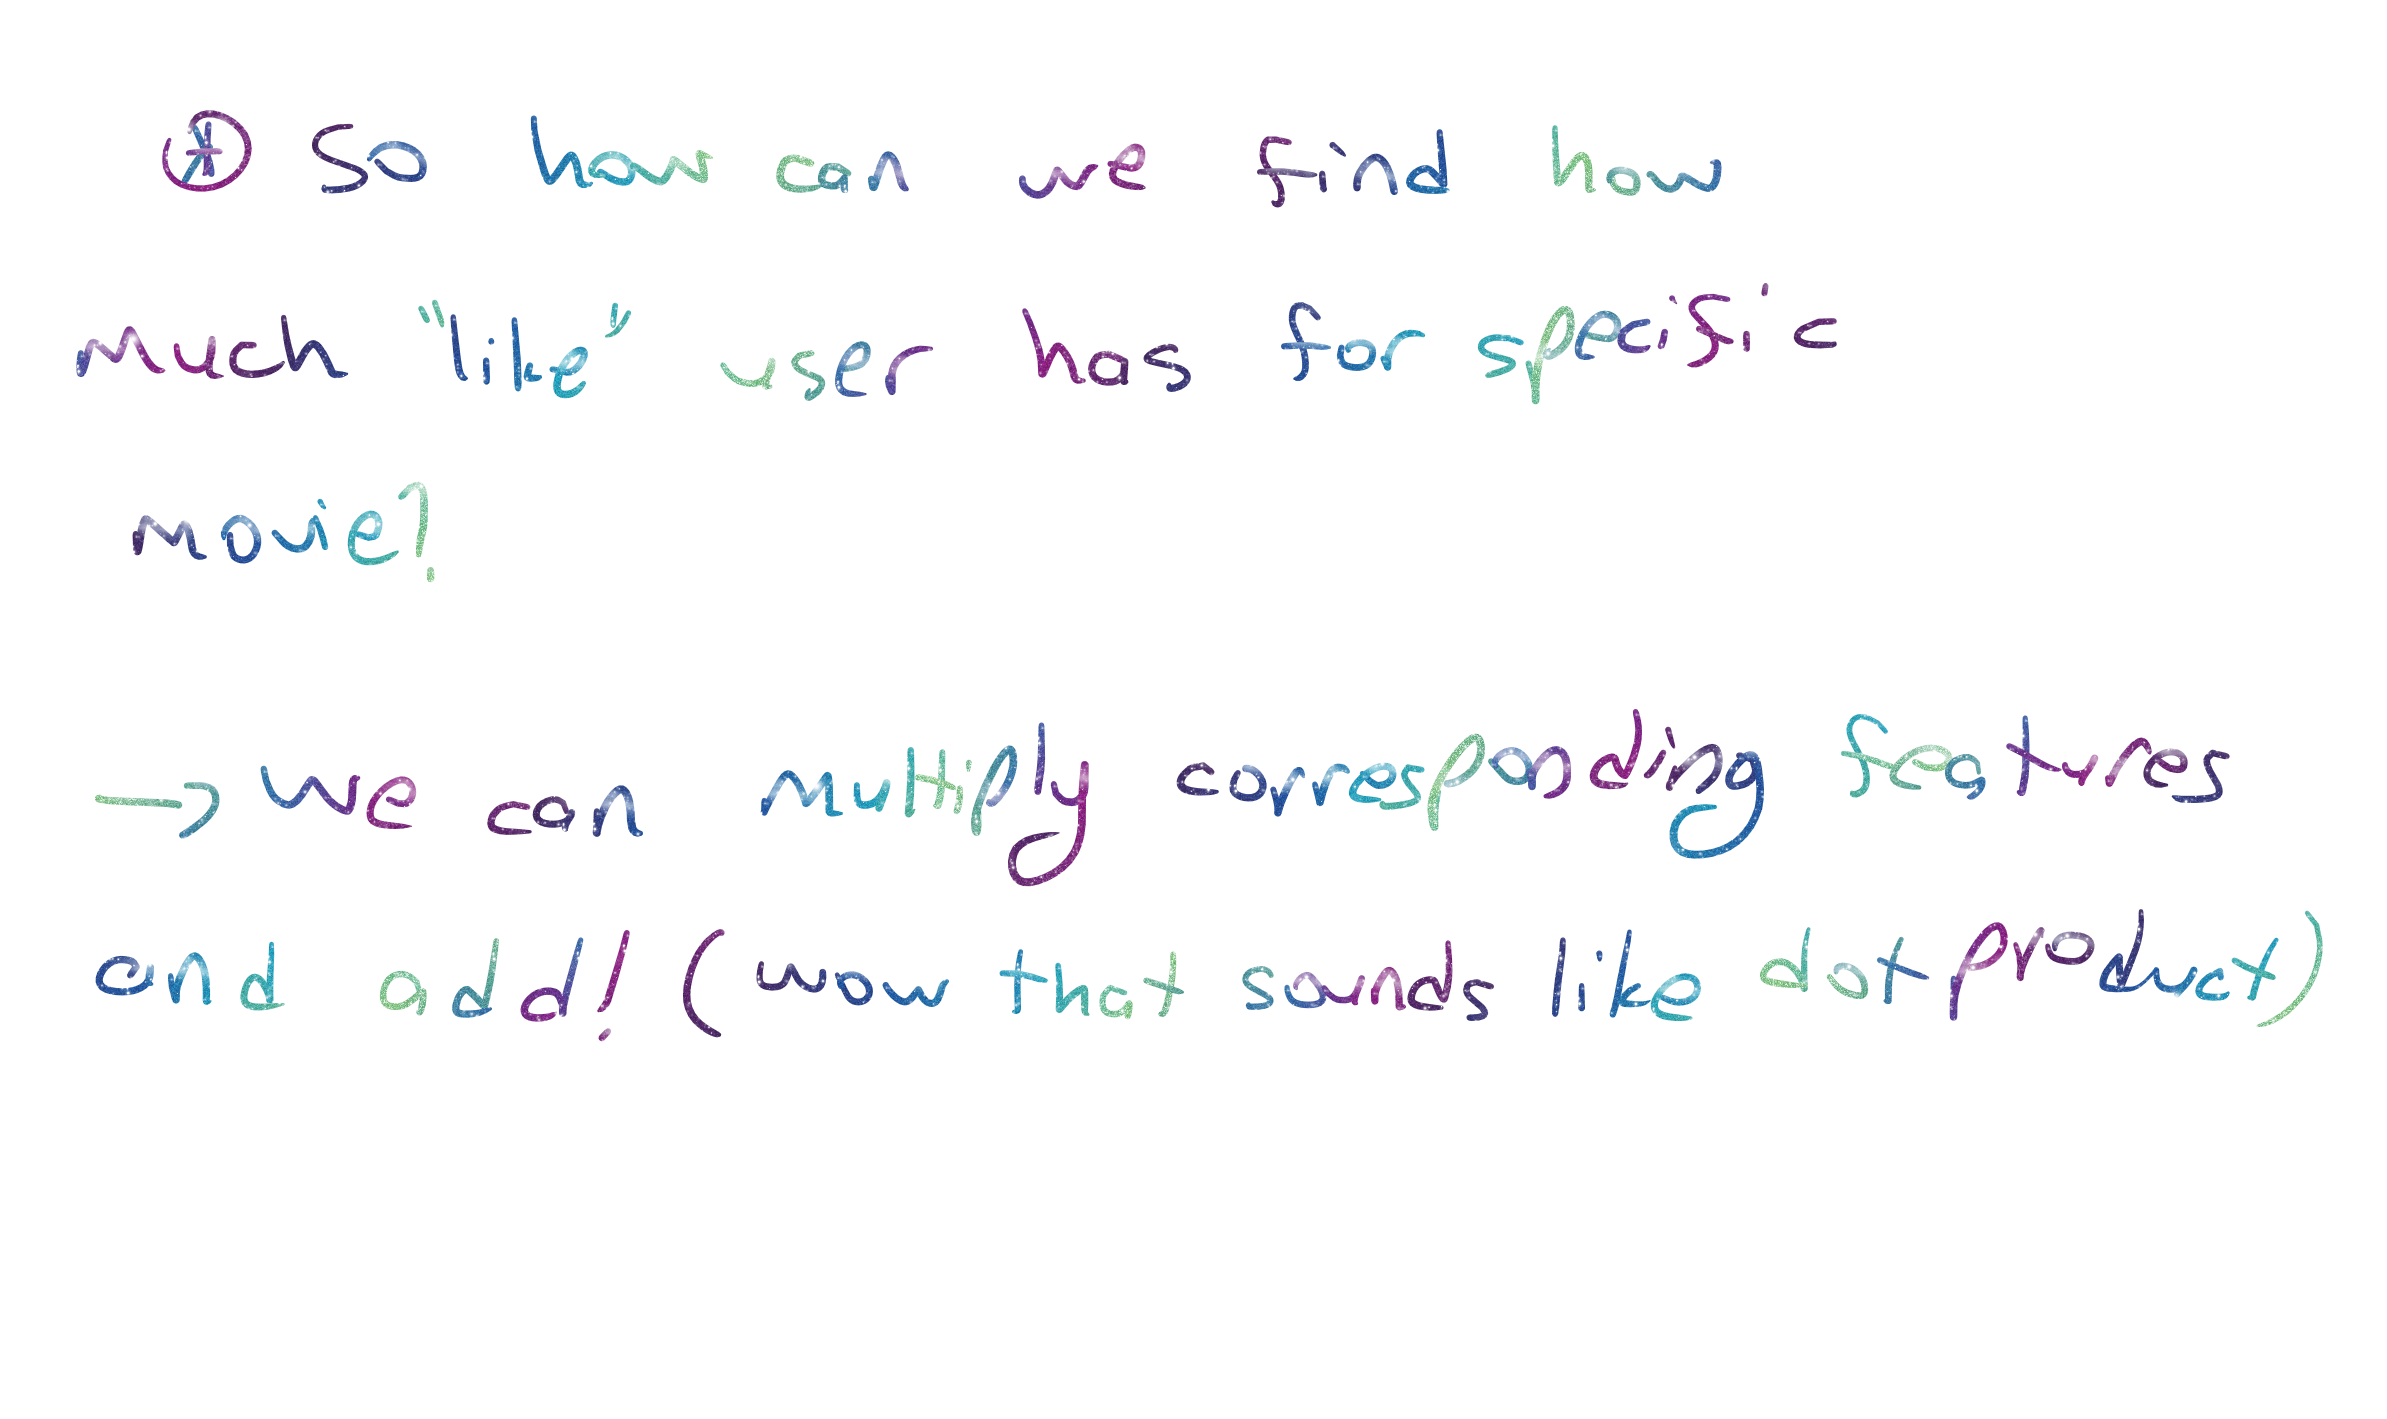

## Data

In [3]:
path = Path("data/ml-100k/")

In [4]:
df_raw = pd.read_csv(path/"u.data", delimiter="\t", header = None,
                 names = ["user", "movie", "rating", "timestamp"])

In [5]:
df_raw.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
df_raw.drop("timestamp", axis = 1, inplace= True)

In [7]:
df_raw.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [8]:
n_users = len(df_raw["user"].unique())
n_users

943

In [9]:
n_movies = len(df_raw["movie"].unique())
n_movies

1682

In [10]:
df_map = df_raw.copy()

## Creating mapping for users and movies

* We will have weigts associated with users and movies, and we will take corresponding ones and feed them to the model.

* But to do that, we should create mapping for movies and users so that when we want to take weights at specific index, we will use mapped values

In [12]:
d_movie = {}
for i, e in enumerate(df_map["movie"].unique()):
    d_movie[e] = i

In [13]:
d_movie

{242: 0,
 302: 1,
 377: 2,
 51: 3,
 346: 4,
 474: 5,
 265: 6,
 465: 7,
 451: 8,
 86: 9,
 257: 10,
 1014: 11,
 222: 12,
 40: 13,
 29: 14,
 785: 15,
 387: 16,
 274: 17,
 1042: 18,
 1184: 19,
 392: 20,
 486: 21,
 144: 22,
 118: 23,
 1: 24,
 546: 25,
 95: 26,
 768: 27,
 277: 28,
 234: 29,
 246: 30,
 98: 31,
 193: 32,
 88: 33,
 194: 34,
 1081: 35,
 603: 36,
 796: 37,
 32: 38,
 16: 39,
 304: 40,
 979: 41,
 564: 42,
 327: 43,
 201: 44,
 1137: 45,
 241: 46,
 4: 47,
 332: 48,
 100: 49,
 432: 50,
 322: 51,
 181: 52,
 196: 53,
 679: 54,
 384: 55,
 143: 56,
 423: 57,
 515: 58,
 20: 59,
 288: 60,
 219: 61,
 526: 62,
 919: 63,
 26: 64,
 232: 65,
 427: 66,
 512: 67,
 15: 68,
 1049: 69,
 416: 70,
 165: 71,
 690: 72,
 248: 73,
 1444: 74,
 5: 75,
 229: 76,
 237: 77,
 480: 78,
 54: 79,
 366: 80,
 518: 81,
 403: 82,
 111: 83,
 625: 84,
 338: 85,
 25: 86,
 1016: 87,
 154: 88,
 275: 89,
 1153: 90,
 498: 91,
 382: 92,
 209: 93,
 23: 94,
 294: 95,
 208: 96,
 685: 97,
 328: 98,
 496: 99,
 132: 100,
 174: 101,


In [14]:
d_user = {}
for i, e in enumerate(df_map["user"].unique()):
    d_user[e] = i

In [15]:
d_user_inverse = {v: k for k, v in d_user.items()}

In [16]:
d_movie_inverse = {v: k for k, v in d_movie.items()}

In [17]:
d_movie_inverse

{0: 242,
 1: 302,
 2: 377,
 3: 51,
 4: 346,
 5: 474,
 6: 265,
 7: 465,
 8: 451,
 9: 86,
 10: 257,
 11: 1014,
 12: 222,
 13: 40,
 14: 29,
 15: 785,
 16: 387,
 17: 274,
 18: 1042,
 19: 1184,
 20: 392,
 21: 486,
 22: 144,
 23: 118,
 24: 1,
 25: 546,
 26: 95,
 27: 768,
 28: 277,
 29: 234,
 30: 246,
 31: 98,
 32: 193,
 33: 88,
 34: 194,
 35: 1081,
 36: 603,
 37: 796,
 38: 32,
 39: 16,
 40: 304,
 41: 979,
 42: 564,
 43: 327,
 44: 201,
 45: 1137,
 46: 241,
 47: 4,
 48: 332,
 49: 100,
 50: 432,
 51: 322,
 52: 181,
 53: 196,
 54: 679,
 55: 384,
 56: 143,
 57: 423,
 58: 515,
 59: 20,
 60: 288,
 61: 219,
 62: 526,
 63: 919,
 64: 26,
 65: 232,
 66: 427,
 67: 512,
 68: 15,
 69: 1049,
 70: 416,
 71: 165,
 72: 690,
 73: 248,
 74: 1444,
 75: 5,
 76: 229,
 77: 237,
 78: 480,
 79: 54,
 80: 366,
 81: 518,
 82: 403,
 83: 111,
 84: 625,
 85: 338,
 86: 25,
 87: 1016,
 88: 154,
 89: 275,
 90: 1153,
 91: 498,
 92: 382,
 93: 209,
 94: 23,
 95: 294,
 96: 208,
 97: 685,
 98: 328,
 99: 496,
 100: 132,
 101: 174,


In [18]:
df_map["user"] = df_map["user"].map(d_user)

In [19]:
df_map["movie"] = df_map["movie"].map(d_movie)

In [20]:
df_map.head()

,user,movie,rating
0,0,0,3
1,1,1,3
2,2,2,1
3,3,3,2
4,4,4,1


## Creating training and validation set

In [21]:
mask = [True if x == 1 else False for x in np.random.uniform(0, 1, (len(df_map))) < 1 - 0.2] 

neg_mask = [not x for x in mask]

In [22]:
train_df, valid_df = df_map[mask], df_map[neg_mask]

In [23]:
df_map.head()

,user,movie,rating
0,0,0,3
1,1,1,3
2,2,2,1
3,3,3,2
4,4,4,1


In [24]:
(train_df["user"] == 0).sum()

36

In [25]:
(valid_df["user"] == 0).sum()

3

## Adding movie titles to our model

* Model will not use titles, it is just for us to visualize which code is which movie

In [37]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [38]:
ratings = df_raw.merge(movies)

In [39]:
ratings

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)
...,...,...,...,...
99995,840,1674,4,Mamma Roma (1962)
99996,655,1640,3,"Eighth Day, The (1996)"
99997,655,1637,3,Girls Town (1996)
99998,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1..."


In [40]:
ratings["user"] = ratings["user"].map(d_user)

In [41]:
ratings["movie"] = ratings["movie"].map(d_movie)

In [42]:
ratings

,user,movie,rating,title
0,0,0,3,Kolya (1996)
1,27,0,3,Kolya (1996)
2,218,0,5,Kolya (1996)
3,156,0,3,Kolya (1996)
4,219,0,5,Kolya (1996)
...,...,...,...,...
99995,831,1677,4,Mamma Roma (1962)
99996,650,1678,3,"Eighth Day, The (1996)"
99997,650,1679,3,Girls Town (1996)
99998,650,1680,3,"Silence of the Palace, The (Saimt el Qusur) (1..."


## Dataset and Dataloader

In [47]:
class Dataset():
    def __init__(self, df): 
        self.df = df
        
    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self, idxs):
        df_sub = self.df.iloc[idxs]
        return (torch.tensor(df_sub["user"].values), torch.tensor(df_sub["movie"].values)), torch.tensor(df_sub["rating"].values, dtype = torch.float32) 
            

In [48]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [49]:
train_ds = Dataset(train_df)
train_dl = DataLoader(train_ds, 64)

In [50]:
valid_ds = Dataset(valid_df)
valid_dl = DataLoader(valid_ds, 64)

## Adjusting sigmoid range

* Model will predict values between 0 and 5. But we will give upper bound as 5.5 since it impossible for model to predict upperbound since sigmoid gives upperbound at infinity

In [52]:
def sigmoid_range(x, low, high): 
    return torch.sigmoid(x) * (high-low) + low

In [177]:
class DotProductBias(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.user_bias = torch.nn.Embedding(n_users, 1)
        self.movie_factors = torch.nn.Embedding(n_movies, n_factors)
        self.movie_bias = torch.nn.Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[0])
        movies = self.movie_factors(x[1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[0]) + self.movie_bias(x[1])
        return sigmoid_range(res, *self.y_range)

* All the embedding module does is to index into tensor, we could do it like:

```python
class DotProductBias(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        super().__init__()
        self.user_factors = nn.Parameter(torch.zeros(n_users, n_factors).normal_())
        self.user_bias = nn.Parameter(torch.zeros(n_users,1).normal_())
        self.movie_factors = nn.Parameter(torch.zeros(n_movies, n_factors).normal_())
        self.movie_bias = nn.Parameter(torch.zeros(n_movies,1).normal_())
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[0]]
        movies = self.movie_factors[x[1]]
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias[x[0]] + self.movie_bias[x[1]]
        return sigmoid_range(res, *self.y_range)
    
    ```

In [54]:
def mean_sqr(preds, targets):
    return ((preds.squeeze() - targets) ** 2).mean()

In [55]:
loss_func = mean_sqr

In [56]:
n_train = len(train_df)
n_train

79889

In [57]:
n_valid = len(valid_df)
n_valid

20111

## bias

* Just giving feature vectors for users and movies might not be enough. Imagine that there is one extraordinarily good scifi movie and even people that do not like scifi likes that movie, so there should be some parameter that is not effected by product. **bias**. We can think the same thing for users too. Maybe someusers are giving bad reviews. Their ratings are low at general. So their bias should be low etc.

In [178]:
def train(model, epochs=5, valid_epoch=5):
    for epoch in range(1, epochs+1):
        model = model.train()
        loss_train = 0
        loss_valid = 0
        for xb, yb in train_dl:
            
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            optim.step()
            optim.zero_grad()
            loss_train += loss * len(xb)
        
        if epoch  % valid_epoch == 0:
            model = model.eval()
            for xb, yb in valid_dl:
                with torch.no_grad():
                    loss_valid += loss_func(model(xb), yb) * len(xb)
            print(f"training loss: {loss_train/n_train} | validation loss: {loss_valid/n_valid}")

In [179]:
model = DotProductBias(n_users, n_movies, 50)

In [89]:
optim = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

In [82]:
optim = torch.optim.SGD(model.parameters(), lr=0.1)

In [180]:
optim = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-3)

In [181]:
train(model,40,2)

training loss: 0.19906339049339294 | validation loss: 0.19927050173282623
training loss: 0.1300719827413559 | validation loss: 0.1354830414056778
training loss: 0.07216013967990875 | validation loss: 0.08110827952623367
training loss: 0.03994717448949814 | validation loss: 0.050798576325178146
training loss: 0.027916522696614265 | validation loss: 0.03764369711279869
training loss: 0.024710072204470634 | validation loss: 0.03255103901028633
training loss: 0.02427009306848049 | validation loss: 0.03039117343723774
training loss: 0.024577589705586433 | validation loss: 0.0293889082968235
training loss: 0.02504153549671173 | validation loss: 0.0289412010461092


KeyboardInterrupt: 

### Interpreting bias

* By this logic, we would expect high biases in good movies

In [163]:
d_movie_title = {}
for e, m in zip(ratings["movie"], ratings["title"]):
    d_movie_title[e] = m

In [164]:
d_movie_title

{0: 'Kolya (1996)',
 1: 'L.A. Confidential (1997)',
 2: 'Heavyweights (1994)',
 3: 'Legends of the Fall (1994)',
 4: 'Jackie Brown (1997)',
 5: 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 6: 'Hunt for Red October, The (1990)',
 7: 'Jungle Book, The (1994)',
 8: 'Grease (1978)',
 9: 'Remains of the Day, The (1993)',
 10: 'Men in Black (1997)',
 11: "Romy and Michele's High School Reunion (1997)",
 12: 'Star Trek: First Contact (1996)',
 13: 'To Wong Foo, Thanks for Everything! Julie Newmar (1995)',
 14: 'Batman Forever (1995)',
 15: 'Only You (1994)',
 16: 'Age of Innocence, The (1993)',
 17: 'Sabrina (1995)',
 18: 'Just Cause (1995)',
 19: 'Endless Summer 2, The (1994)',
 20: 'Man Without a Face, The (1993)',
 21: 'Sabrina (1954)',
 22: 'Die Hard (1988)',
 23: 'Twister (1996)',
 24: 'Toy Story (1995)',
 25: 'Broken Arrow (1996)',
 26: 'Aladdin (1992)',
 27: 'Casper (1995)',
 28: 'Restoration (1995)',
 29: 'Jaws (1975)',
 30: 'Chasing Amy (1997)',
 31

In [182]:
movie_bias = model.movie_bias.weight.squeeze()
idxs = movie_bias.argsort()[:5]
[d_movie_title[i.item()] for i in idxs]

['Bio-Dome (1996)',
 'Leave It to Beaver (1997)',
 'Island of Dr. Moreau, The (1996)',
 'Very Brady Sequel, A (1996)',
 'Cable Guy, The (1996)']

In [183]:
idxs = movie_bias.argsort(descending = True)[:5]
[d_movie_title[i.item()] for i in idxs]

["Schindler's List (1993)",
 'Star Wars (1977)',
 'Shawshank Redemption, The (1994)',
 'Casablanca (1942)',
 'Godfather, The (1972)']

### pca

In [184]:
d_title_movie = {}
for e, m in zip(ratings["movie"], ratings["title"]):
    d_title_movie[m] = e

In [185]:
def pca(x:torch.tensor, k=2):
    "Compute PCA of `x` with `k` dimensions."
    x = x-torch.mean(x,0)
    U,S,V = torch.svd(x.t())
    return torch.mm(x,U[:,:k])

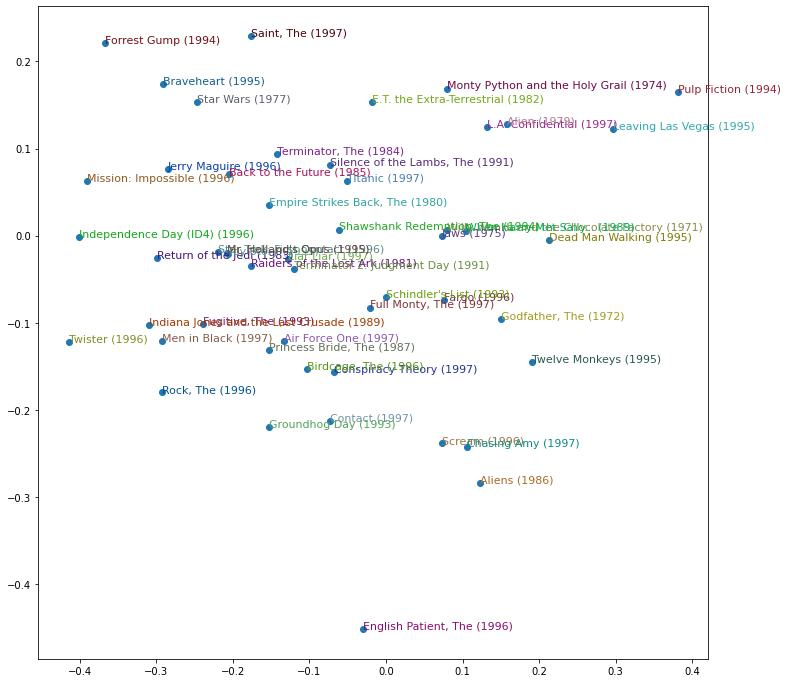

In [186]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = torch.tensor([d_title_movie[m] for m in top_movies])
movie_w = model.movie_factors(top_idxs).cpu().detach()
movie_pca = pca(movie_w,3)
fac0,fac1,fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Deep Learning aproach

In [ ]:
class DotProductBias(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.user_bias = torch.nn.Embedding(n_users, 1)
        self.movie_factors = torch.nn.Embedding(n_movies, n_factors)
        self.movie_bias = torch.nn.Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[0])
        movies = self.movie_factors(x[1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[0]) + self.movie_bias(x[1])
        return sigmoid_range(res, *self.y_range)

In [207]:
class collab_deep(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5), n_act=100):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.movie_factors = torch.nn.Embedding(n_movies, n_factors)
        self.layers = nn.Sequential(
            nn.Linear(2 * n_factors, n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[0]),self.movie_factors(x[1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [208]:
model2 = collab_deep(n_users, n_movies, 50)

In [209]:
optim = torch.optim.SGD(model2.parameters(), lr=0.1, weight_decay=1e-3)

In [210]:
train(model2,40,2)

training loss: 0.03281194344162941 | validation loss: 0.03383680805563927
training loss: 0.02987356297671795 | validation loss: 0.031133804470300674
training loss: 0.028258642181754112 | validation loss: 0.03042852133512497
training loss: 0.027057070285081863 | validation loss: 0.030577175319194794


KeyboardInterrupt: 

In [215]:
class collab_deep_2(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5), n_act=100):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.movie_factors = torch.nn.Embedding(n_movies, n_factors)
        self.layers = nn.Sequential(
            nn.Linear(2 * n_factors + 1, n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[0])
        movies = self.movie_factors(x[1])
        embs = users,movies, (users*movies).sum(dim=1, keepdim = True)
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [216]:
model3 = collab_deep_2(n_users, n_movies, 50)

In [217]:
optim = torch.optim.SGD(model3.parameters(), lr=0.1, weight_decay=1e-3)

In [218]:
train(model3,40,2)

training loss: 0.03382354974746704 | validation loss: 0.033738620579242706
training loss: 0.0304420068860054 | validation loss: 0.03280385583639145
training loss: 0.02866089716553688 | validation loss: 0.03282805159687996
training loss: 0.027374321594834328 | validation loss: 0.02999747358262539
training loss: 0.026279266923666 | validation loss: 0.03101801499724388
training loss: 0.0253619197756052 | validation loss: 0.029960019513964653
training loss: 0.024464638903737068 | validation loss: 0.029595356434583664
training loss: 0.023630250245332718 | validation loss: 0.028895419090986252


KeyboardInterrupt: 